## Семинарский ноутбук 2. CLIP

### Стартовый инференс

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
from collections import OrderedDict
import os
from pkg_resources import packaging

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage
import torch

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
# preprocess — трансформация для картинок (resize, crop, нормализация)

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution # с каким размером картинки ждёт модель
context_length = model.context_length # максимальная длина текстового ввода (кол-во токенов)
vocab_size = model.vocab_size # размер словаря токенизатора

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 126MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


> `skimage` - это библиотека scikit-image.
>
> Python-библиотека для обработки изображений (часть экосистемы SciPy).
>
> В ней есть функции для фильтрации, сегментации, морфологии и т.п.
>
> Плюс есть модуль `skimage.data` с небольшим набором демонстрационных картинок.


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
skimage.data.download_all()

# словарь: name → текстовое описание
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

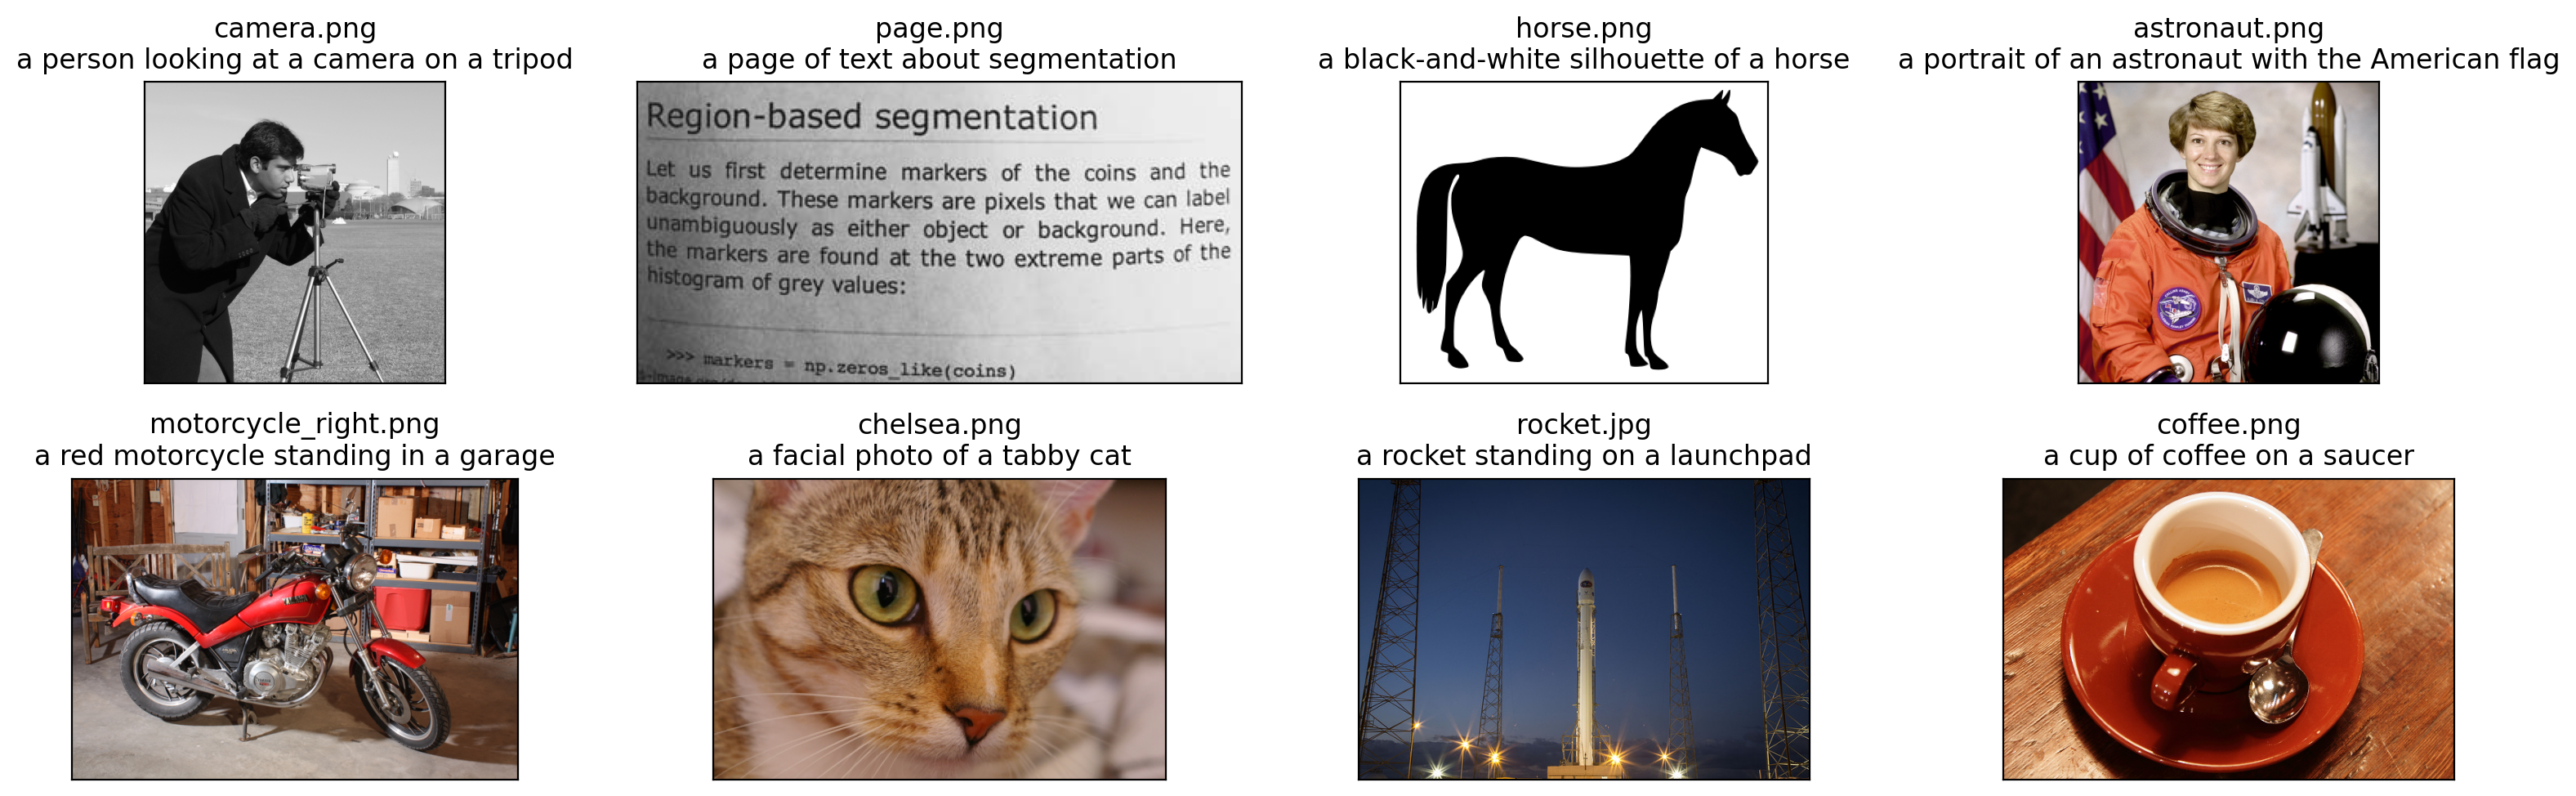

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

# Идём по всем .png/.jpg в skimage.data_dir
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]

    # берём только те, для которых есть описание в description
    if name not in descriptions:
        continue

    # приводим к RGB
    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    # создаем датасет - это препроцессор клипа
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

```
preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=BICUBIC), # размер под клип
    transforms.CenterCrop(224), # обрезка
    transforms.ToTensor(), # [0,1] -> тензор
    transforms.Normalize(mean=..., std=...), # нормализация по каналам
])

```

In [ ]:
# складываем список тензоров картинок в один батч
image_input = torch.tensor(np.stack(images)).cuda()

# добавляем промпт
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [ ]:
image_input.size()

torch.Size([8, 3, 224, 224])

In [ ]:
# эмбедим текст и картинки
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [ ]:
text_features.size()

torch.Size([8, 512])

In [ ]:
# L2-нормировка по последней оси
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# матричное произведение: [n_text, d] @ [d, n_image] -> [n_text, n_image]
# векторы нормированы -это фактически косинусные сходства
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

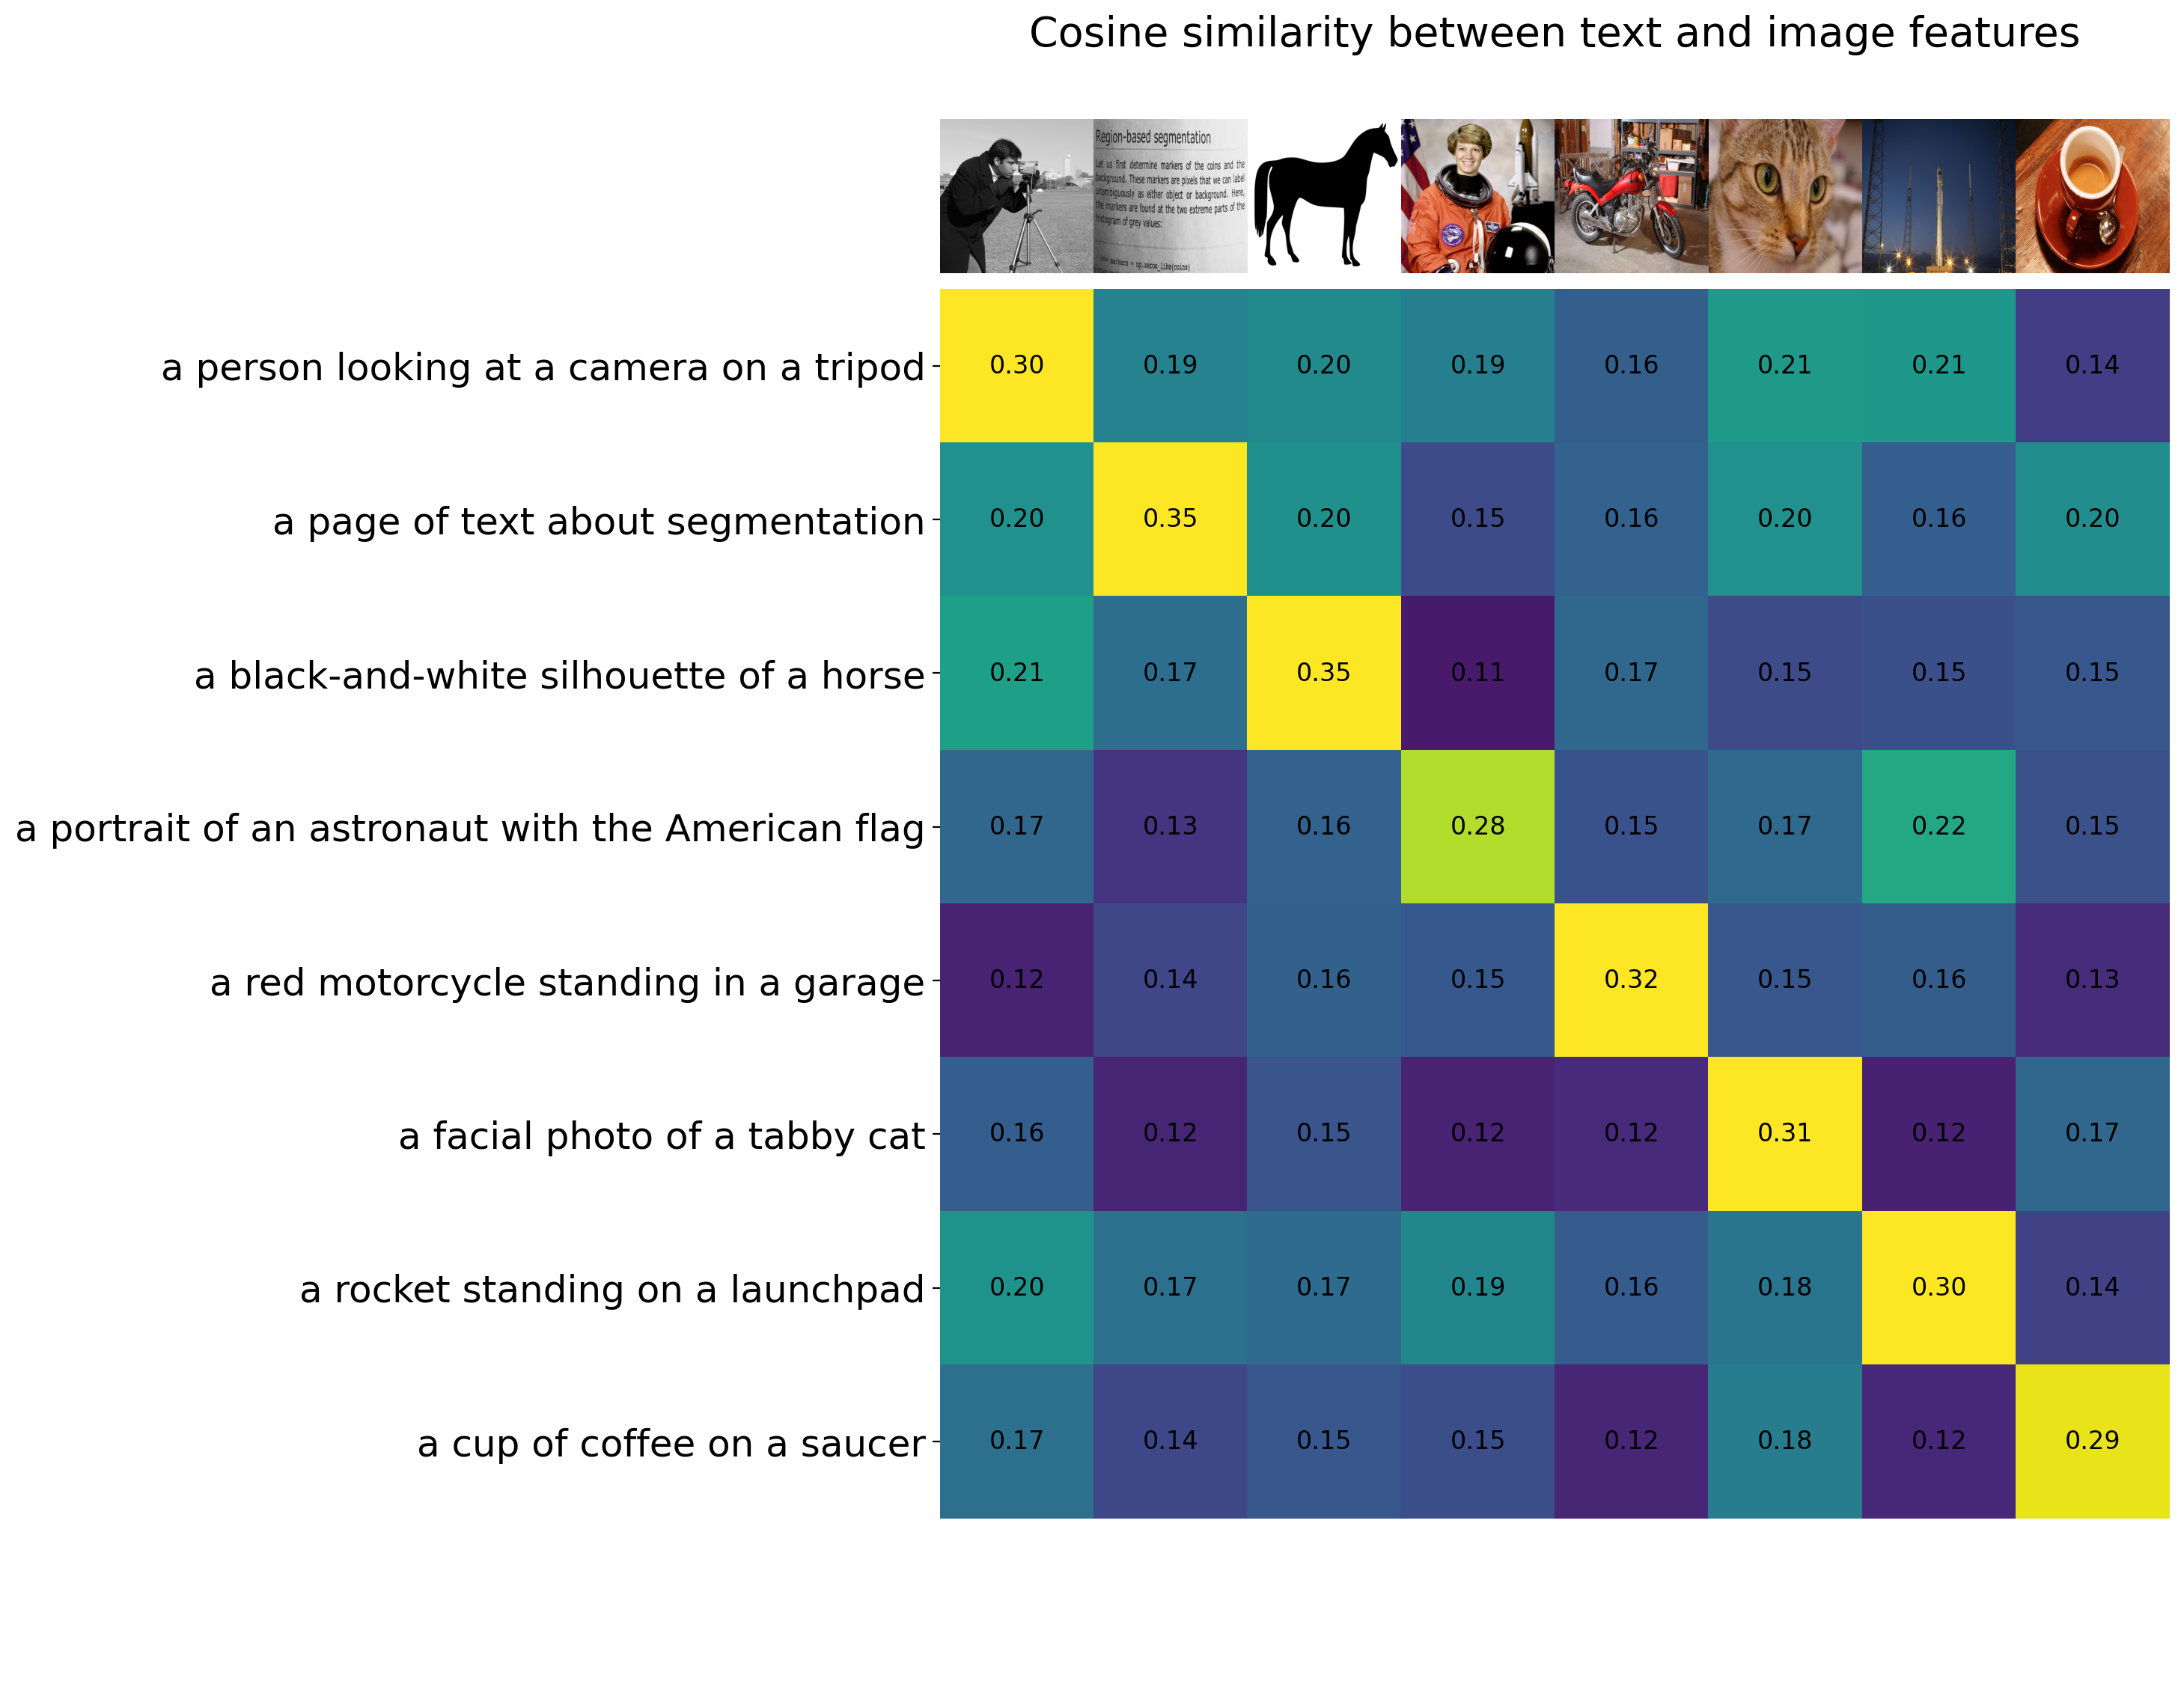

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))

# heatmap косинусов
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])

for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# косинус в каждой ячейке
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

### Zero-shot классификация на CIFAR-100

In [ ]:
from torchvision.datasets import CIFAR100

# можно передать transform=preprocess, чтобы картинки приводились к формату CLIP
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169M/169M [00:14<00:00, 11.9MB/s]


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes[:500]]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
cifar_images = [preprocess(Image.fromarray(i)) for i in cifar100.data[:500]]

In [ ]:
# батч [500, 3, H, W]
cifar_images = torch.stack(cifar_images).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    image_features = model.encode_image(cifar_images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # кодировали бы сырые numpy-картинки
    # image_features = model.encode_image(torch.from_numpy(cifar100.data).permute(0,3,1,2)).float()

# умножаем на 100 для "острого" softmax (температура)
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
for i in range(10):
    print(f'Sample {i} top_5 {top_labels[i]}. Target {cifar100.targets[i]} {cifar100.classes[i]}')

Sample 0 top_5 tensor([41, 19, 89, 15, 83]). Target 19 apple
Sample 1 top_5 tensor([29, 59, 27, 63, 56]). Target 29 aquarium_fish
Sample 2 top_5 tensor([ 0, 83, 47, 57, 52]). Target 0 baby
Sample 3 top_5 tensor([11, 83, 35, 98, 46]). Target 11 bear
Sample 4 top_5 tensor([ 1, 41, 27, 96, 29]). Target 1 beaver
Sample 5 top_5 tensor([83, 22,  1, 92, 26]). Target 86 bed
Sample 6 top_5 tensor([90, 81, 13, 83, 60]). Target 90 bee
Sample 7 top_5 tensor([28, 60, 10, 61, 92]). Target 28 beetle
Sample 8 top_5 tensor([49, 23, 60, 59, 12]). Target 23 bicycle
Sample 9 top_5 tensor([31, 15, 21, 29, 83]). Target 31 bottle


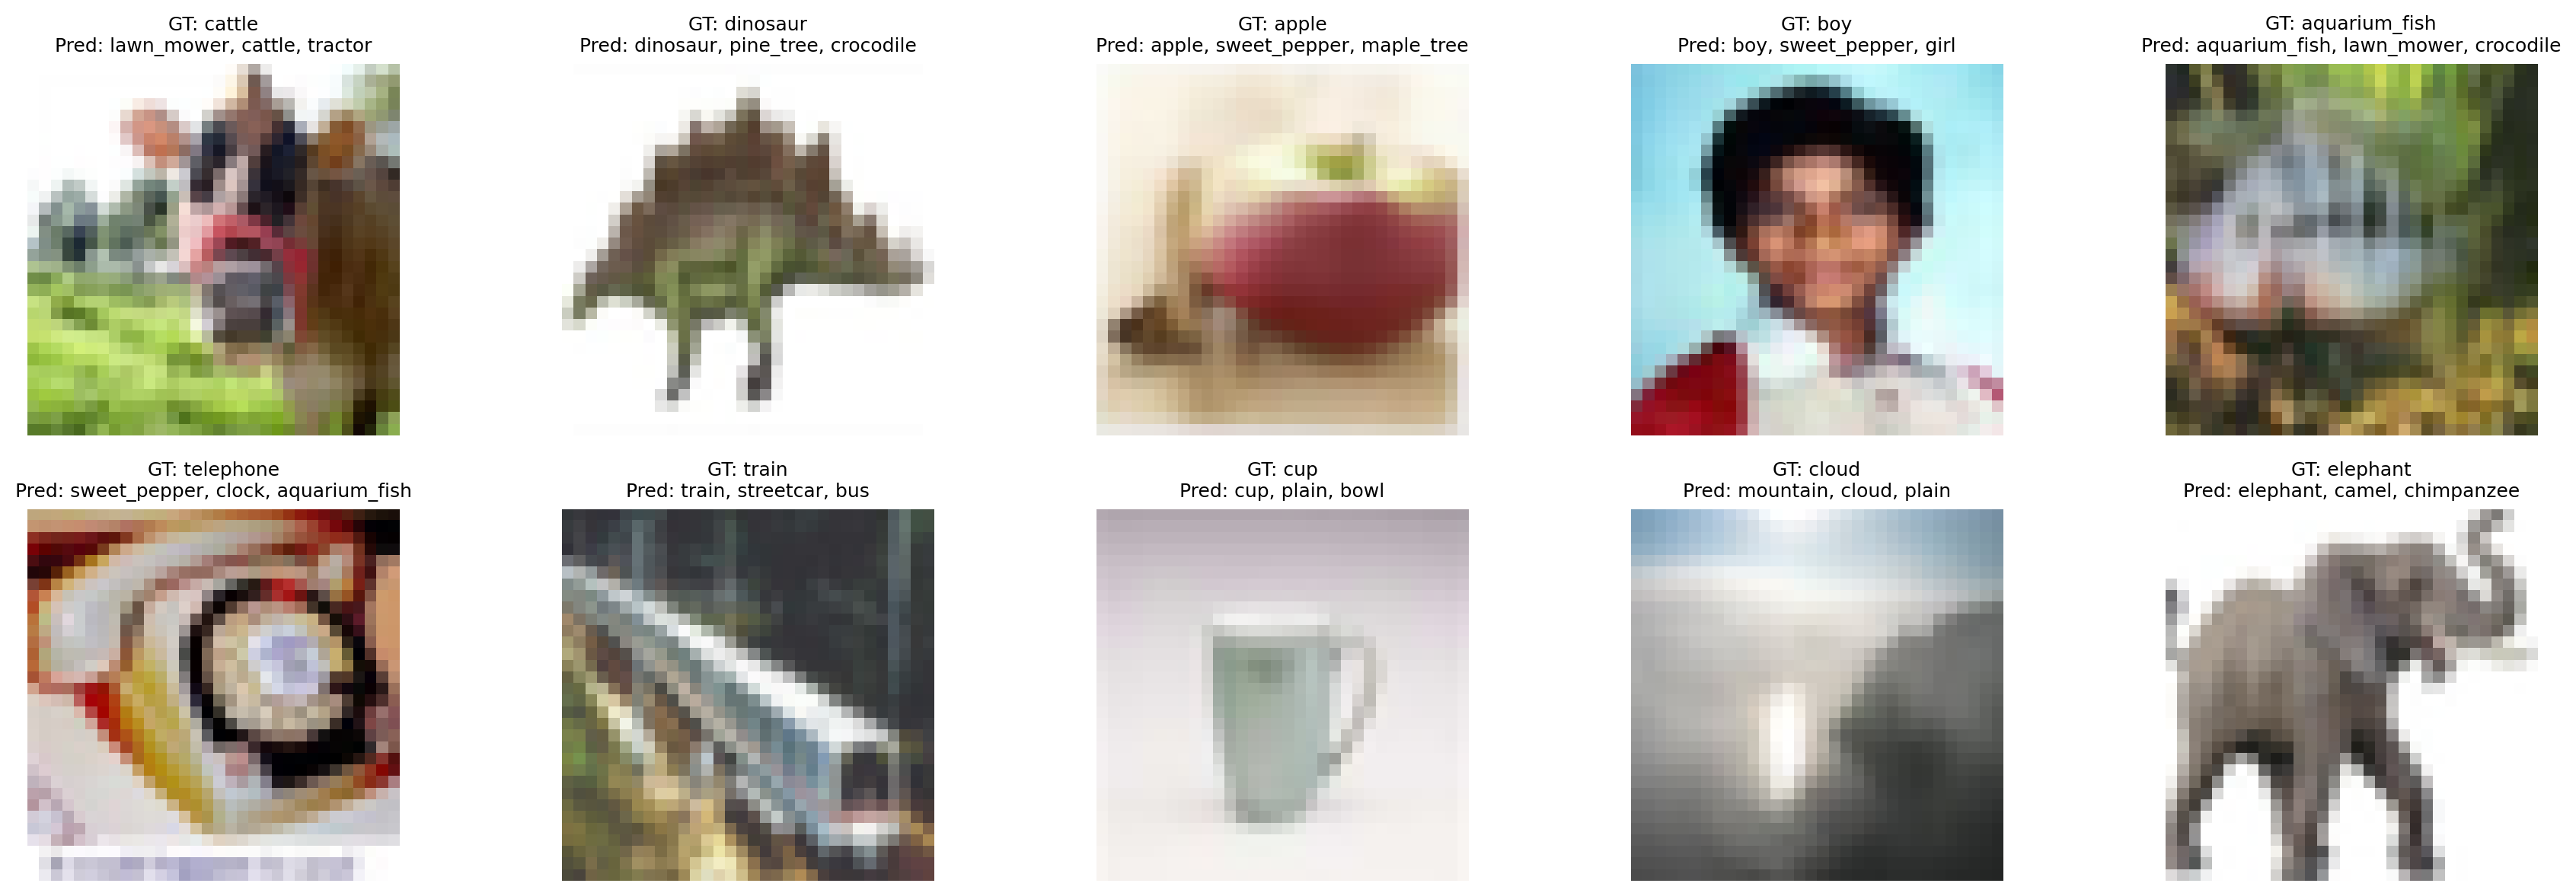

In [ ]:
n_show = 10

plt.figure(figsize=(18, 6))

for i in range(n_show):
    plt.subplot(2, 5, i + 1)

    img = cifar100.data[i] # shape (32, 32, 3), uint8
    plt.imshow(img)
    plt.axis("off")

    true_idx = cifar100.targets[i]
    true_label = cifar100.classes[true_idx]

    pred_indices = top_labels[i].tolist()
    pred_labels = [cifar100.classes[j] for j in pred_indices]

    title_pred = ", ".join(pred_labels[:3])
    plt.title(f"GT: {true_label}\nPred: {title_pred}", fontsize=9)

plt.tight_layout()
plt.show()

> CIFAR-100 просто очень низкого разрешения :(

### HuggingFace CLIPModel/CLIPProcessor

> Набор данных [COCO](https://docs.ultralytics.com/ru/datasets/detect/coco/) (Common Objects in Context) - это масштабный набор данных для обнаружения объектов, сегментации и создания подписей.

In [ ]:
import requests
from transformers import CLIPProcessor, CLIPModel

# те же веса ViT-B/32
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# из COCO
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

This is a photo of a cat with proba 99.49%
This is a photo of a dog with proba 0.51%


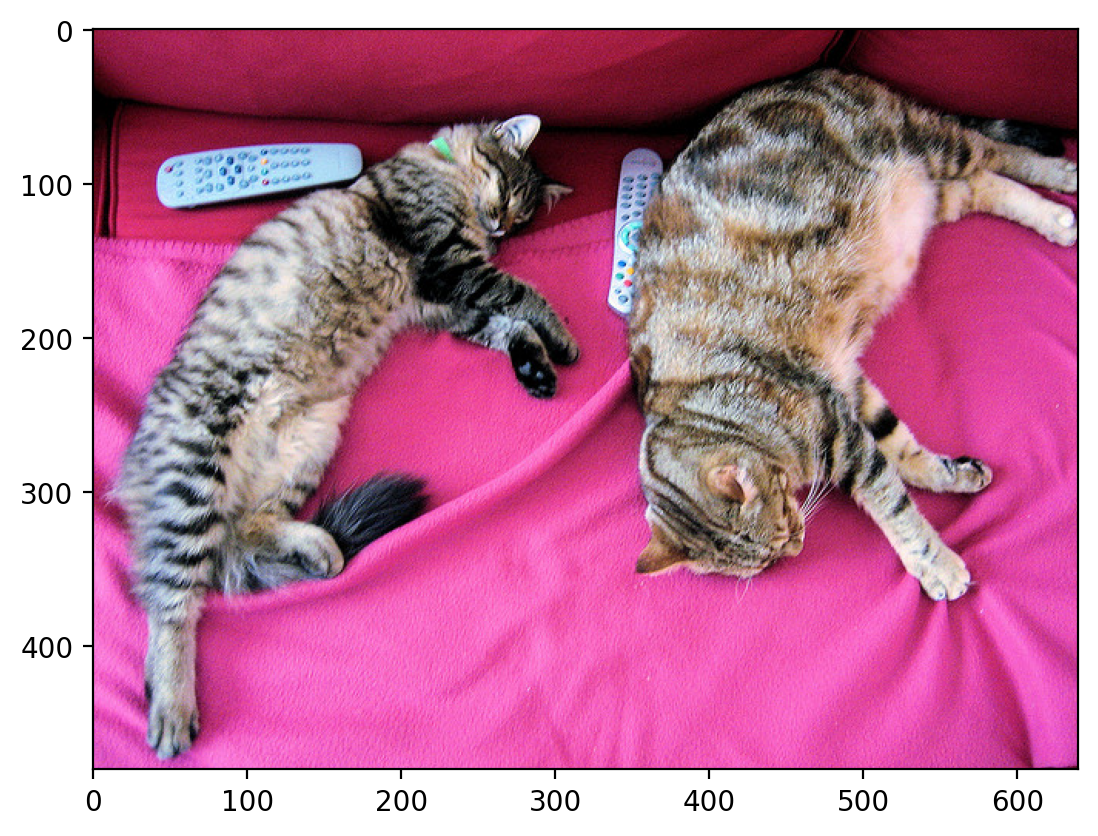

In [ ]:
# текстовые гипотезы
hypo = ["a photo of a cat", "a photo of a dog"]

# Processor сам:
# токенизирует тексты
# препроцессит картинку
# формирует нужные тензоры для модели
inputs = processor(
    text=hypo,
    images=image,
    return_tensors="pt",
    padding=True,
)
outputs = model(**inputs)

# логиты
logits_per_image = outputs.logits_per_image

# превращаем логиты в вероятности по двум классам
probs = logits_per_image.softmax(dim=1)

plt.imshow(image)
for h, p in zip(hypo, probs[0]):
    print(f'This is {h} with proba {p:.2%}')

In [ ]:
# структуру батча (что там внутри)
inputs

{'pixel_values': tensor([[[[ 0.5873,  0.5873,  0.6165,  ...,  0.0617,  0.0471, -0.0259],
          [ 0.5727,  0.5727,  0.6603,  ...,  0.1201,  0.0763,  0.0909],
          [ 0.5873,  0.5435,  0.6165,  ...,  0.0325,  0.1201,  0.0617],
          ...,
          [ 1.8719,  1.8573,  1.8719,  ...,  1.3902,  1.4340,  1.4194],
          [ 1.8281,  1.8719,  1.8427,  ...,  1.4486,  1.4340,  1.5070],
          [ 1.8573,  1.9011,  1.8281,  ...,  1.3756,  1.3610,  1.4486]],

         [[-1.3169, -1.3019, -1.3169,  ..., -1.4970, -1.4369, -1.4820],
          [-1.2418, -1.2718, -1.2268,  ..., -1.4369, -1.4669, -1.4519],
          [-1.2568, -1.3169, -1.2268,  ..., -1.4669, -1.4069, -1.4519],
          ...,
          [ 0.1239,  0.1089,  0.1239,  ..., -0.7016, -0.6865, -0.6865],
          [ 0.0789,  0.0939,  0.0488,  ..., -0.6565, -0.6865, -0.6115],
          [ 0.0939,  0.1089,  0.0038,  ..., -0.7766, -0.7316, -0.6115]],

         [[-0.4848, -0.4137, -0.3853,  ..., -0.9541, -0.8545, -0.8545],
          [-0

```
'pixel_values': tensor([1, 3, H, W]), # 1 изображение
'input_ids': tensor([
  [49406, 320, 1125, 539, 320, 2368, 49407], # "a photo of a cat"
  [49406, 320, 1125, 539, 320, 1929, 49407], # "a photo of a dog"
])
```